In [13]:
import tensorflow as tf;
import os;
import cv2;
import numpy as np;
import tqdm;
from sklearn.preprocessing import LabelBinarizer;
import matplotlib.pyplot as plt

In [5]:
BASE_PATH = '/Users/nibabi/Desktop/skateboard_trick_classification/Tricks'
VIDEOS_PATH = os.path.join(BASE_PATH, '**','*.mov')
SEQUENCE_LENGTH = 300

In [6]:
"""
 version_2
"""

import tensorflow as tf
import cv2
import numpy as np


def frame_generator():
    video_paths = tf.io.gfile.glob(VIDEOS_PATH)
    np.random.shuffle(video_paths)
    for video_path in video_paths:
        
        cap = cv2.VideoCapture(video_path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_every_frame = max(1, num_frames // SEQUENCE_LENGTH)
        current_frame = 0
        
        max_images = SEQUENCE_LENGTH
        while True:
            success, frame = cap.read()
            if not success:
                break

            if current_frame % sample_every_frame == 0:
                # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
                frame = frame[:, :, ::-1]
                img = tf.image.resize(frame, (299, 299))
                img = tf.keras.applications.inception_v3.preprocess_input(img)
                max_images -= 1
                
                yield img, video_path

            current_frame += 1

            if max_images == 0:
                break

dataset = tf.data.Dataset.from_generator(frame_generator,
             output_types=(tf.float32, tf.string),
             output_shapes=((299, 299, 3), ()))

dataset = dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

    

In [2]:
"""
用新数据生成特征
"""
MY_PATH = os.path.join('/Users/nibabi/Desktop/skateboard_trick_classification/Tricks/normal_ollie','*.mp4')
SEQUENCE_LENGTH = 300


def frame_generator():
    video_paths = tf.io.gfile.glob(MY_PATH)
    np.random.shuffle(video_paths)
    for video_path in video_paths:
        
        cap = cv2.VideoCapture(video_path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_every_frame = max(1, num_frames // SEQUENCE_LENGTH)
        current_frame = 0
        
        max_images = SEQUENCE_LENGTH
        while True:
            success, frame = cap.read()
            if not success:
                break

            if current_frame % sample_every_frame == 0:
                # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
                frame = frame[:, :, ::-1]
                img = tf.image.resize(frame, (299, 299))
                img = tf.keras.applications.inception_v3.preprocess_input(img)
                max_images -= 1
                
                yield img, video_path

            current_frame += 1

            if max_images == 0:
                break

kf_test_set = tf.data.Dataset.from_generator(frame_generator,
             output_types=(tf.float32, tf.string),
             output_shapes=((299, 299, 3), ()))

kf_test_set = kf_test_set.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

x = inception_v3.output

pooling_output = tf.keras.layers.GlobalMaxPooling2D()(x)

feature_extraction_model = tf.keras.Model(inception_v3.input, pooling_output)

current_path = None
all_features = []

for img, batch_paths in tqdm.tqdm(kf_test_set):
    batch_features = feature_extraction_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))
    
    for features, path in zip(batch_features.numpy(), batch_paths.numpy()):
        if path != current_path and current_path is not None:
            output_path = current_path.decode().replace('.mp4', '.npy')
            np.save(output_path, all_features)
            all_features = []
            
        current_path = path
        all_features.append(features)
        
if all_features:
    output_path = current_path.decode().replace('.mp4', '.npy')
    np.save(output_path, all_features)

0it [00:00, ?it/s]2023-11-16 16:30:16.876868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-16 16:30:16.937990: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
282it [03:55,  1.20it/s]


In [ ]:
# # '''
# # 生成图像帧数据
# # '''
# def frame_generator():
#     video_paths = tf.io.gfile.glob(VIDEOS_PATH)
#     np.random.shuffle(video_paths)
#     for video_path in video_paths:
        
#         cap = cv2.VideoCapture(video_path)
#         num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         sample_every_frame = max(1, num_frames // SEQUENCE_LENGTH)
#         current_frame = 0
        
#         max_images = SEQUENCE_LENGTH
#         while True:
#             success, frame = cap.read()
#             if not success:
#                 break

#             if current_frame % sample_every_frame == 0:
#                 # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
#                 frame = frame[:, :, ::-1]
#                 img = tf.image.resize(frame, (299, 299))
#                 img = tf.keras.applications.inception_v3.preprocess_input(img)
#                 max_images -= 1
                
#                 yield img, video_path
                

#         if max_images == 0:
#             break
#         current_frame += 1

# dataset = tf.data.Dataset.from_generator(frame_generator,
#              output_types=(tf.float32, tf.string),
#              output_shapes=((299, 299, 3), ()))

# dataset = dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)



In [8]:
inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

x = inception_v3.output

pooling_output = tf.keras.layers.GlobalAveragePooling2D()(x)

feature_extraction_model = tf.keras.Model(inception_v3.input, pooling_output)



In [ ]:
current_path = None
all_features = []

for img, batch_paths in tqdm.tqdm(dataset):
    batch_features = feature_extraction_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))
    
    for features, path in zip(batch_features.numpy(), batch_paths.numpy()):
        if path != current_path and current_path is not None:
            output_path = current_path.decode().replace('.mov', '.npy')
            np.save(output_path, all_features)
            all_features = []
            
        current_path = path
        all_features.append(features)

In [ ]:
# current_path = None
# all_features = []
# for img, batch_paths in tqdm.tqdm(dataset):
#     batch_features = feature_extraction_model(img)
#     batch_features = tf.reshape(batch_features, 
#                               (batch_features.shape[0], -1))
    
#     for features, path in zip(batch_features.numpy(), batch_paths.numpy()):
#         if path != current_path and current_path is not None:
#             # 在保存之前，确保所有特征向量的长度都是 SEQUENCE_LENGTH
#             while len(all_features) < SEQUENCE_LENGTH:
#                 all_features.append(np.zeros(2048))  # 或者使用其他方式填充
#             output_path = current_path.decode().replace('.mp4', '.npy')
#             np.save(output_path, all_features)
#             all_features = []
            
#         current_path = path
#         all_features.append(features)

In [ ]:
# from tensorflow.keras import regularizers
# LABELS = ['Ollie','Kickflip','Shuvit'] 
# encoder = LabelBinarizer()
# encoder.fit(LABELS)

# model = tf.keras.Sequential([
#     tf.keras.layers.Masking(mask_value=0.),
#     tf.keras.layers.LSTM(512, dropout=0.5, recurrent_dropout=0.5),  # 添加 L2 正则化
#     tf.keras.layers.Dense(256, activation='relu'),  # 添加 L2 正则化
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(LABELS), activation='softmax')
# ])

# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy', 'top_k_categorical_accuracy'])

In [9]:
LABELS = ['Ollie','Kickflip','Shuvit'] 
encoder = LabelBinarizer()
encoder.fit(LABELS)

def generate_lstmfcn(MAX_SEQUENCE_LENGTH, NB_CLASS, NUM_CELLS=8):

    ip = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,2048))

    x = tf.keras.layers.LSTM(NUM_CELLS)(ip)
    x = tf.keras.layers.Dropout(0.5)(x)

    y = tf.keras.layers.Permute((2, 1))(ip)
    y = tf.keras.layers.Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)
    y =  tf.keras.layers.Dropout(0.5)(y)

    y = tf.keras.layers.Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)
    y =  tf.keras.layers.Dropout(0.5)(y)

    y = tf.keras.layers.Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)
    y =  tf.keras.layers.Dropout(0.5)(y)

    y = tf.keras.layers.GlobalAveragePooling1D()(y)

    x = tf.keras.layers.concatenate([x, y])
    
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # 添加额外的全连接层
    x = tf.keras.layers.Dropout(0.5)(x)

    out = tf.keras.layers.Dense(NB_CLASS, activation='softmax')(x)

    model = tf.keras.Model(ip, out)

    model.summary()

    # add load model code here to fine-tune

    return model

In [10]:
with open('/Users/nibabi/Desktop/skateboard_trick_classification/Test_list.txt') as f:
    test_list = [row.strip() for row in list(f)]

with open('/Users/nibabi/Desktop/skateboard_trick_classification/Train_list.txt') as f:
    train_list = [row.strip() for row in list(f)]
    train_list = [row.split(' ')[0] for row in train_list]


In [11]:
def make_generator(file_list):
    def generator():
        np.random.shuffle(file_list)
        for path in file_list:
            full_path = os.path.join(BASE_PATH + '/', path).replace('.mov', '.npy')

            label = os.path.basename(os.path.dirname(path))
            features = np.load(full_path)

            padded_sequence = np.zeros((SEQUENCE_LENGTH, 2048))
            padded_sequence[0:len(features)] = np.array(features)

            transformed_label = encoder.transform([label])
            yield padded_sequence, transformed_label[0]
    return generator

train_dataset = tf.data.Dataset.from_generator(make_generator(train_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 2048), (len(LABELS))))
train_dataset = train_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_generator(make_generator(test_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 2048), (len(LABELS))))
valid_dataset = valid_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300, 2048)]  0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 2048, 300)    0           ['input_5[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 2048, 128)    307328      ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_285 (Batch  (None, 2048, 128)   512         ['conv1d_3[0][0]']               
 Normalization)                                                                             

2023-11-16 16:46:20.780865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-16 16:46:20.781686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-16 16:46:20.782168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-11-16 16:46:21.019834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-16 16:46:21.020686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-16 16:46:21.021279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     11/Unknown - 6s 468ms/step - loss: 0.6384 - accuracy: 0.4375 - top_k_categorical_accuracy: 1.0000

2023-11-16 16:46:27.333170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-16 16:46:27.333722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-16 16:46:27.334354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 7s 490ms/step - loss: 0.6377 - accuracy: 0.4407 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4981 - val_accuracy: 0.7045 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/200
12/12 [==============================] - 5s 427ms/step - loss: 0.5390 - accuracy: 0.5989 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4534 - val_accuracy: 0.6591 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/200
12/12 [==============================] - 6s 506ms/step - loss: 0.4944 - accuracy: 0.6215 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4387 - val_accuracy: 0.6591 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/200
12/12 [==============================] - 5s 445ms/step - loss: 0.4661 - accuracy: 0.6102 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4325 - val_accuracy: 0.6591 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/200
12/12 [==============================] - 6s 480ms/step - loss: 0.4410 - accuracy: 0.7232 - top_k_categorical_accurac

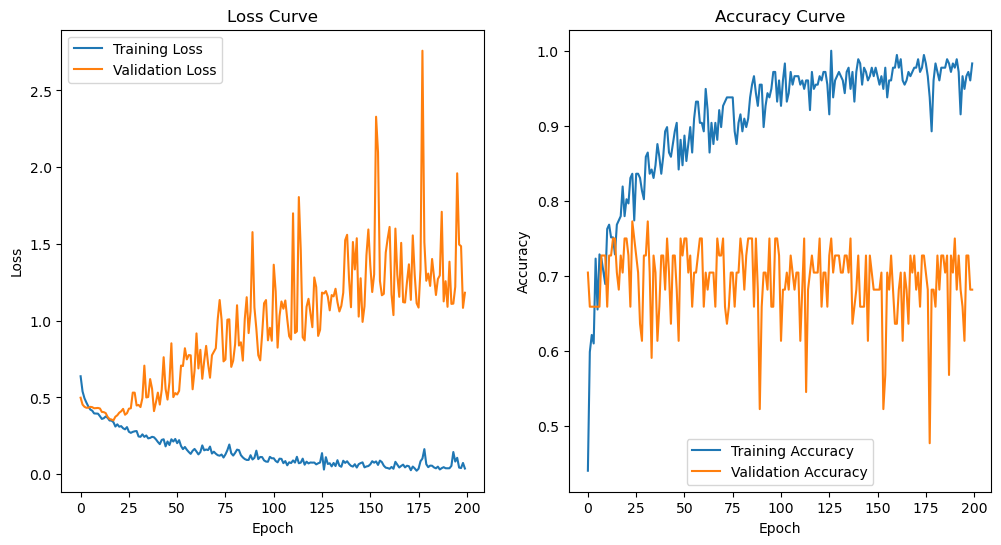

In [14]:
# 构建模型
MAX_SEQUENCE_LENGTH = 300
NB_CLASS = 3
model = generate_lstmfcn(MAX_SEQUENCE_LENGTH, NB_CLASS)

# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy', 'top_k_categorical_accuracy'])


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log', update_freq=1000)
history = model.fit(train_dataset, epochs=200, callbacks=[tensorboard_callback], validation_data=valid_dataset)

# 提取训练和验证的损失和准确度
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确度曲线
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log', update_freq=1000)
model.fit(train_dataset, epochs=20, callbacks=[tensorboard_callback], validation_data=valid_dataset)

In [ ]:
import matplotlib.pyplot as plt

# 模型训练的历史记录
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)

# 提取训练和验证的损失和准确度
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确度曲线
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
"""
用自己的数据测试
"""
MY_PATH = os.path.join('/Users/nibabi/Desktop/skateboard_trick_classification/Tricks/Test_Kickflip','*.mp4')
SEQUENCE_LENGTH = 40


def frame_generator():
    video_paths = tf.io.gfile.glob(MY_PATH)
    np.random.shuffle(video_paths)
    for video_path in video_paths:
        
        cap = cv2.VideoCapture(video_path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_every_frame = max(1, num_frames // SEQUENCE_LENGTH)
        current_frame = 0
        
        max_images = SEQUENCE_LENGTH
        while True:
            success, frame = cap.read()
            if not success:
                break

            if current_frame % sample_every_frame == 0:
                # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
                frame = frame[:, :, ::-1]
                img = tf.image.resize(frame, (299, 299))
                img = tf.keras.applications.inception_v3.preprocess_input(img)
                max_images -= 1
                
                yield img, video_path

            current_frame += 1

            if max_images == 0:
                break

ol_test_set = tf.data.Dataset.from_generator(frame_generator,
             output_types=(tf.float32, tf.string),
             output_shapes=((299, 299, 3), ()))

ol_test_set = ol_test_set.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

x = inception_v3.output

pooling_output = tf.keras.layers.GlobalAveragePooling2D()(x)

feature_extraction_model = tf.keras.Model(inception_v3.input, pooling_output)

current_path = None
all_features = []

for img, batch_paths in tqdm.tqdm(ol_test_set):
    batch_features = feature_extraction_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))
    
    for features, path in zip(batch_features.numpy(), batch_paths.numpy()):
        if path != current_path and current_path is not None:
            output_path = current_path.decode().replace('.mp4', '.npy')
            np.save(output_path, all_features)
            all_features = []
            
        current_path = path
        all_features.append(features)

In [ ]:
# with open('/Users/nibabi/Desktop/skateboard_trick_classification/Test_ollie.txt') as f:
#     ol_test = [row.strip() for row in list(f)]
    
# def make_generator(file_list):
#     def generator():
        
#         for path in file_list:
#             full_path = os.path.join(BASE_PATH + '/', path).replace('.mp4', '.npy')

#             # label = os.path.basename(os.path.dirname(path))
#             features = np.load(full_path)

#             padded_sequence = np.zeros((SEQUENCE_LENGTH, 2048))
#             padded_sequence[0:len(features)] = np.array(features)

#             # transformed_label = encoder.transform([label])
#             # yield padded_sequence, transformed_label[0]
#     return generator

# my_ol_dataset = tf.data.Dataset.from_generator(make_generator(ol_test),
#                  output_types=(tf.float32, tf.int16),
#                  output_shapes=((SEQUENCE_LENGTH, 2048), (len(LABELS))))
# my_ol_dataset = my_ol_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
with open('/Users/nibabi/Desktop/skateboard_trick_classification/Test_list.txt') as f:
    ol_test = [row.strip() for row in list(f)]

def make_generator(file_list):
    def generator():
        for path in file_list:
            full_path = os.path.join(BASE_PATH + '/', path).replace('.mov', '.npy')
            features = np.load(full_path)

            padded_sequence = np.zeros((SEQUENCE_LENGTH, 2048))
            padded_sequence[0:len(features)] = np.array(features)


            yield padded_sequence  # 不生成标签

    return generator

my_ol_dataset = tf.data.Dataset.from_generator(
    make_generator(ol_test),
    output_types=tf.float32,  # 只有特征，不需要定义标签的类型
    output_shapes=(SEQUENCE_LENGTH, 2048)  # 只有特征的形状
)

my_ol_dataset = my_ol_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

predict = model.predict(my_ol_dataset)
print(predict)
predicted_labels = np.argmax(predict, axis=1)
print(predicted_labels)
# Kickflip = predict[:,1]
# print(Kickflip)
# x = np.arange(len(Kickflip))
# plt.scatter(x, Kickflip)
Ollie = predict[:,0]
x = np.arange(len(Ollie))
plt.scatter(x, Ollie)



# conf_matrix = confusion_matrix(y_true, y_pred)

# # 使用 seaborn 绘制混淆矩阵的热力图
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
